In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tuyetnhi811_data_aquatic_path = kagglehub.dataset_download('tuyetnhi811/data-aquatic')

print('Data source import complete.')


100%|██████████| 122M/122M [00:01<00:00, 91.2MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import các thư viện cần thiết để sử dụng

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import LearningRateScheduler

Khai báo các biến cấu hình (hyperparameters) cần thiết, sử dụng trong lúc huấn luyện

In [ ]:
BATCH_SIZE       = 32
IMG_SIZE         = (224, 224)
NUM_CLASSES      = 9
DATA_DIR         = tuyetnhi811_data_aquatic_path
VALIDATION_SPLIT = 0.10
TEST_SPLIT       = 0.05
SEED             = 123

Quét dữ liệu ảnh từ dataset và gán nhãn số (label) tương ứng cho từng ảnh Sắp xếp tên lớp theo thứ tự alpha

In [ ]:
file_paths, labels = [], []
class_names = sorted(os.listdir(DATA_DIR))
class_to_index = {n:i for i,n in enumerate(class_names)}
nb_classes = len(class_to_index)

In ra số lượng class và danh sách class gồm label và class_name

In [ ]:
print(f"Number of classes: {nb_classes}")
print("Class names:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

Number of classes: 9
Class names:
0: Crabs_
1: Lobster_
2: Octopus_
3: Otter_
4: Puffers_
5: Sea Urchins_
6: Seahorse_
7: Squid_
8: Starfish_


Vẽ biểu đồ phân bố số lượng ảnh theo từng class trong dataset

<ipython-input-7-6073ae78ef24>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_vals, y=y_labels, palette='Set3')


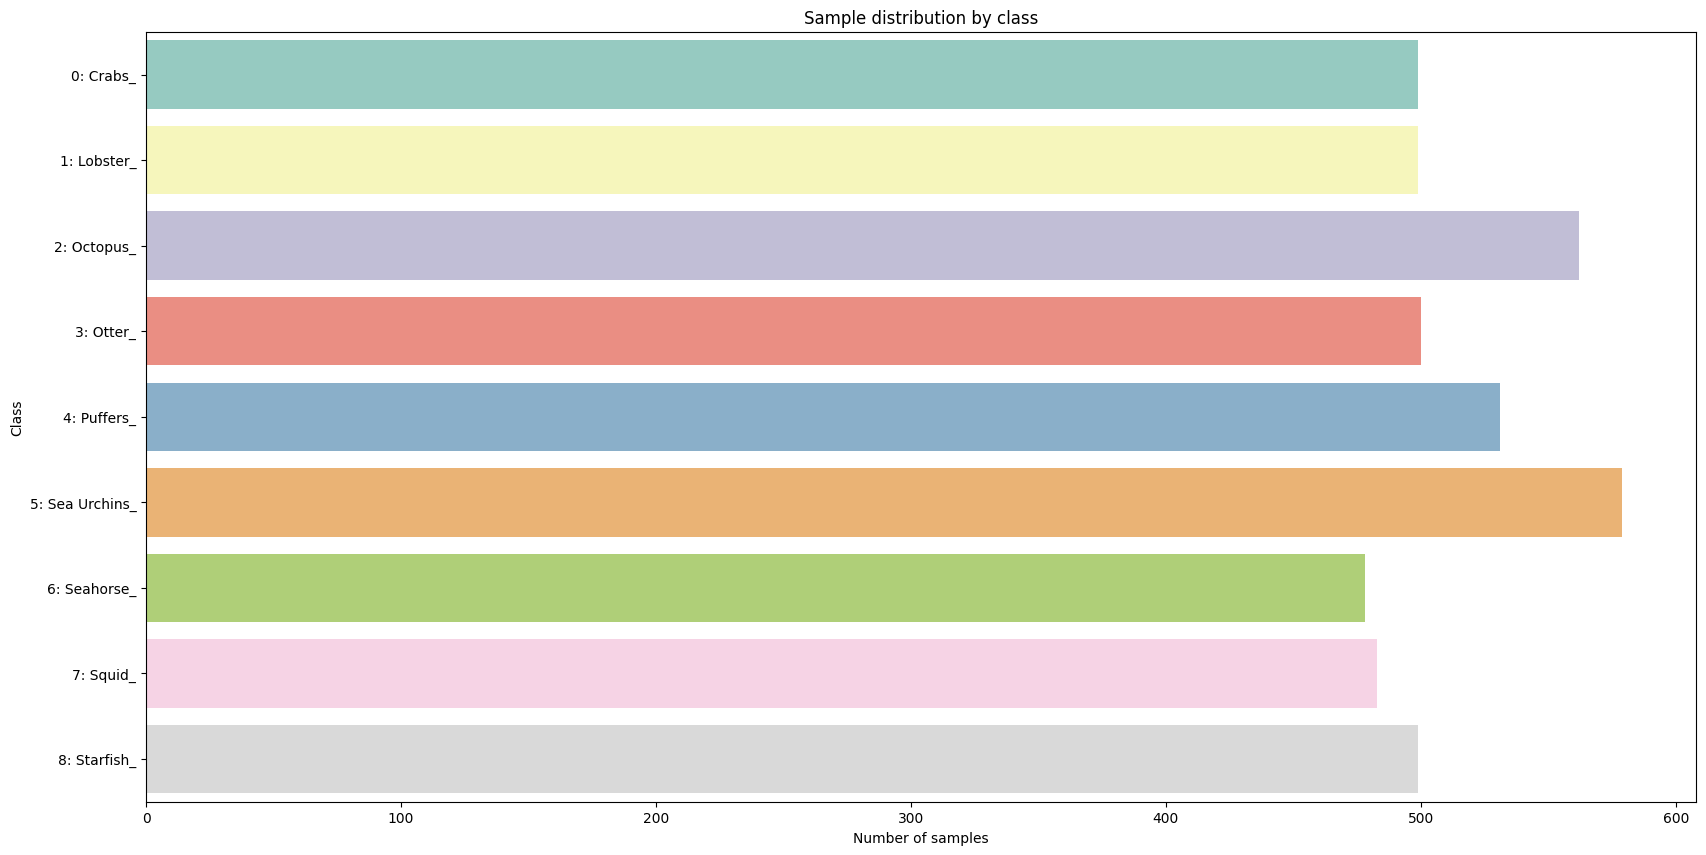

In [ ]:
plt.figure(figsize=(20, 10))
x_vals = [len(os.listdir(os.path.join(DATA_DIR, class_name))) for class_name in class_names]
y_labels = [f"{class_to_index[class_name]}: {class_name}" for class_name in class_names]
sns.barplot(x=x_vals, y=y_labels, palette='Set3')
plt.xlabel('Number of samples')
plt.ylabel('Class')
plt.title('Sample distribution by class')
plt.show()

Hiển thị mỗi class 3 ảnh ngẫu nhiên để kiểm tra trực quan dữ liệu trong dataset

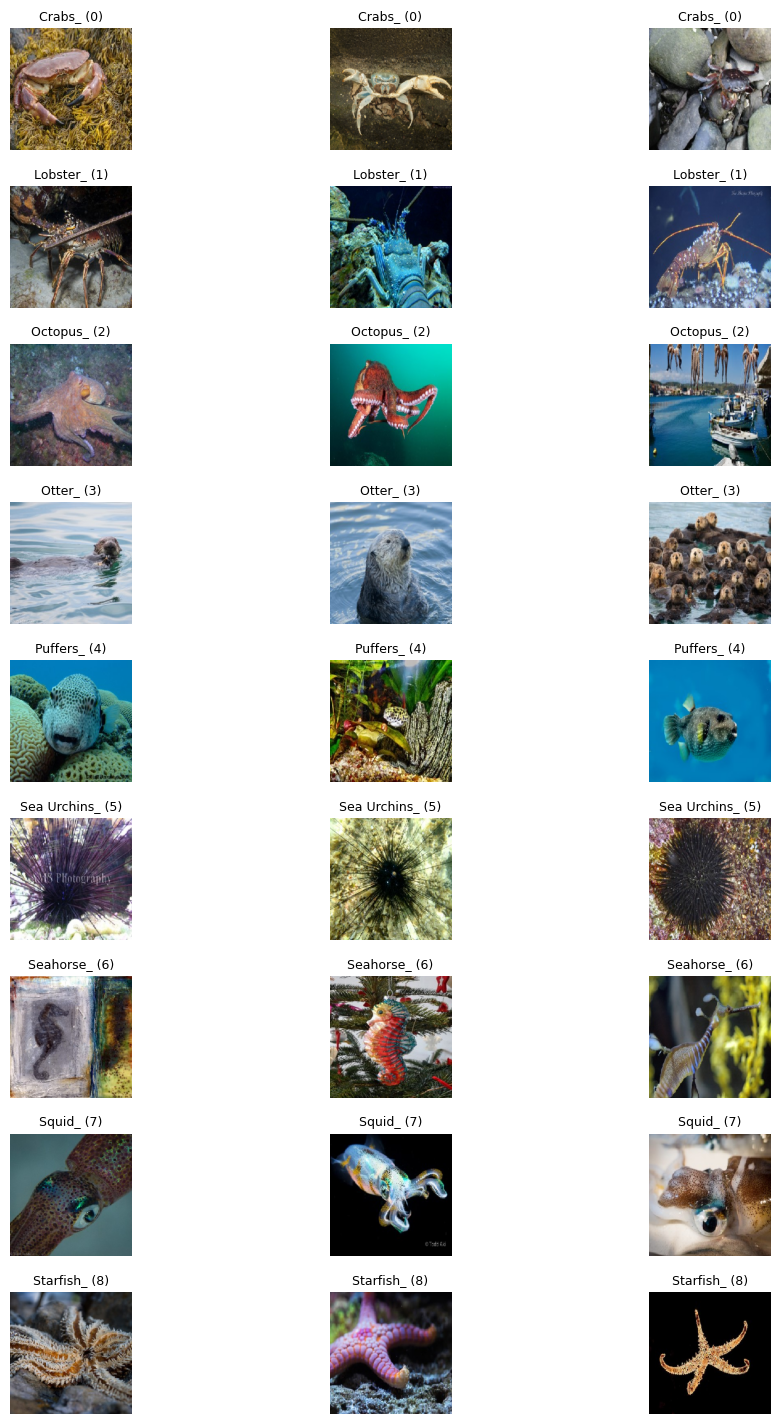

In [ ]:
SAMPLES_PER_CLASS = 3

plt.figure(figsize=(12, nb_classes * 2))  # giảm chiều rộng và chiều cao tổng thể

for i, cls in enumerate(class_names):
    cls_dir = os.path.join(DATA_DIR, cls)
    all_images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('jpg','png','jpeg'))]

    sample_images = np.random.choice(all_images, min(SAMPLES_PER_CLASS, len(all_images)), replace=False)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(cls_dir, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img).astype('uint8')

        ax = plt.subplot(nb_classes, SAMPLES_PER_CLASS, i * SAMPLES_PER_CLASS + j + 1)
        ax.imshow(img_array)
        ax.axis('off')
        ax.set_title(f"{cls} ({class_to_index[cls]})", fontsize=9)

plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

Tạo tập huấn luyện và tập kiểm tra

In [ ]:
for cls in class_names:
    cls_dir = os.path.join(DATA_DIR, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('jpg','png','jpeg')):
            file_paths.append(os.path.join(cls_dir, fname))
            labels.append(class_to_index[cls])

ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
ds = ds.shuffle(len(file_paths), seed=SEED)

val_size = int(len(file_paths) * VALIDATION_SPLIT)
test_size = int(len(file_paths) * TEST_SPLIT)

val_ds = ds.take(val_size)
test_ds = ds.skip(val_size).take(test_size)
train_ds = ds.skip(val_size + test_size)

Tóm tắt số lượng ảnh trong tập train, validation và test

In [ ]:
total_images = len(file_paths)
train_size = total_images - val_size - test_size

print(f"Total number of images: {total_images}")
print(f"Number of training images: {train_size}")
print(f"Number of validation images: {val_size}")
print(f"Number of test images: {test_size}")

Total number of images: 4630
Number of training images: 3936
Number of validation images: 463
Number of test images: 231


Tiền xử lý ảnh, tăng cường dữ liệu bằng cách tạo layer xoay ngẫu nhiên trong khoảng 20 độ

In [ ]:
# Preprocess & Augmentation
# tạo layer xoay
rotation_layer = layers.RandomRotation(factor=0.2)  # xoay ±20%

def preprocess(path, label, training):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = rotation_layer(img)                # áp dụng xoay ở đây
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: preprocess(x,y,True),
                        num_parallel_calls=AUTOTUNE) \
                   .batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: preprocess(x,y,False),
                      num_parallel_calls=AUTOTUNE) \
                 .batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: preprocess(x, y, False),
                      num_parallel_calls=AUTOTUNE) \
                 .batch(BATCH_SIZE).prefetch(AUTOTUNE)

Xây dựng kiến trúc MobileNetV2 từ đầu

In [ ]:


def conv_bn_relu(x, filters, kernel_size, strides=1, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x) if activation == 'relu' else x

def depthwise_separable_conv(x, filters, strides=1, expansion=6):
    input_filters = x.shape[-1]
    # Expansion (pointwise conv)
    x = conv_bn_relu(x, input_filters * expansion, 1)
    # Depthwise conv
    x = layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Pointwise conv (projection)
    x = layers.Conv2D(filters, 1, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return x

def inverted_residual_block(x, filters, strides=1, expansion=6, first_block=False):
    shortcut = x
    x = depthwise_separable_conv(x, filters, strides=strides, expansion=expansion)

    # Skip connection if input and output shapes match
    if strides == 1 and shortcut.shape[-1] == filters and not first_block:
        x = layers.add([x, shortcut])
    return x

def build_mobilenetv2(input_shape, num_classes, alpha=1.0):
    inputs = layers.Input(shape=input_shape)

    # Initial conv layer
    x = conv_bn_relu(inputs, int(32 * alpha), 3, strides=2)

    # Inverted residual blocks configuration: (expansion, filters, num_blocks, stride)
    block_configs = [
        (1, 16, 1, 1),
        (6, 24, 2, 2),
        (6, 32, 3, 2),
        (6, 64, 4, 2),
        (6, 96, 3, 1),
        (6, 160, 3, 2),
        (6, 320, 1, 1),
    ]

    first_block = True
    for expansion, filters, num_blocks, stride in block_configs:
        filters = int(filters * alpha)
        # First block in each group may have stride > 1
        x = inverted_residual_block(x, filters, strides=stride, expansion=expansion, first_block=first_block)
        first_block = False
        # Remaining blocks in the group have stride=1
        for _ in range(num_blocks - 1):
            x = inverted_residual_block(x, filters, strides=1, expansion=expansion)

    # Final layers
    x = conv_bn_relu(x, int(1280 * alpha), 1)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, x)

# Build MobileNetV2 model
model = build_mobilenetv2(IMG_SIZE + (3,), NUM_CLASSES)

Hiển thị kiến trúc mô hình vừa xây dựng

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 32)   │          1,024 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 112, 112, 32)   │            288 │ re_lu_1[0][0]          │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 16)   │            512 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 96)   │          1,536 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 96)   │            384 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 112, 112, 96)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 56, 56, 96)     │            864 │ re_lu_3[0][0]          │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,270,665 (8.66 MB)

 Trainable params: 2,236,489 (8.53 MB)

 Non-trainable params: 34,176 (133.50 KB)

Điều chỉnh learning rate qua từng giai đoạn (ở đây là mỗi 10 epoch 1 lần giảm)

In [ ]:
def step_decay(epoch):
    initial_lr = 1e-3
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

In [ ]:
scheduler = LearningRateScheduler(step_decay, verbose=1)

Biên dịch mô hình

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Train mô hình

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    verbose=1,
    callbacks=scheduler
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 292ms/step - accuracy: 0.1948 - loss: 2.2369 - val_accuracy: 0.1274 - val_loss: 2.8155 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 53s 246ms/step - accuracy: 0.3278 - loss: 1.8705 - val_accuracy: 0.0994 - val_loss: 3.0957 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 40s 240ms/step - accuracy: 0.3798 - loss: 1.7381 - val_accuracy: 0.1123 - val_loss: 3.5126 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 239ms/step - accuracy: 0.4250 - loss: 1.5901 - val_accuracy: 0.1253 - val_loss: 3.8067 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - acc

Lưu mô hình cuối cùng

In [ ]:
model.save('/content/my_model.h5')

Vẽ biểu đồ tiến trình huấn luyện của hai tập train và validation dựa vào hai giá trị:

Accuracy
Loss

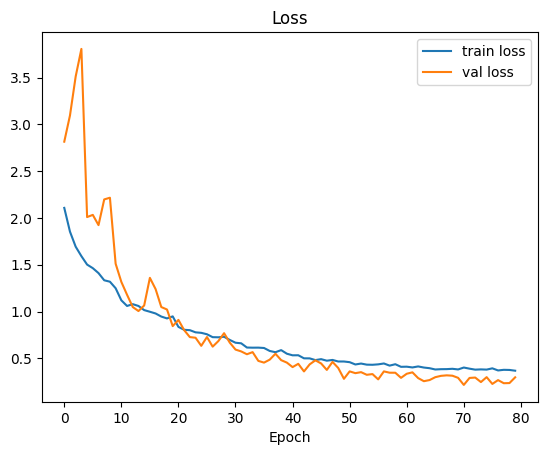

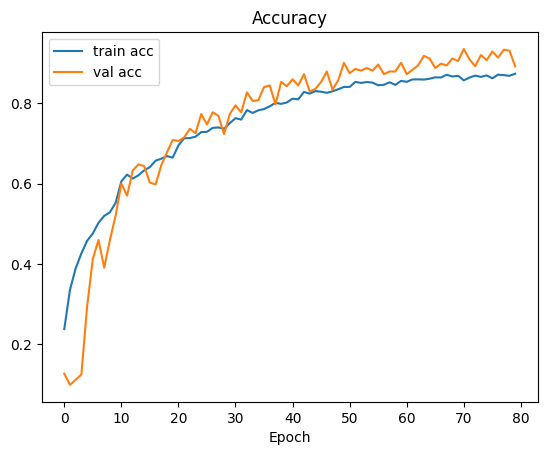

In [ ]:
def plot_history(h):
    plt.figure()
    plt.plot(h.history['loss'], label='train loss')
    plt.plot(h.history['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss'); plt.xlabel('Epoch'); plt.show()

    plt.figure()
    plt.plot(h.history['accuracy'], label='train acc')
    plt.plot(h.history['val_accuracy'], label='val acc')
    plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.show()

plot_history(history)

Bảng đánh giá kết quả huấn luyện mô hình trên tập Validation, in ra bảng báo cáo phân loại cho từng class. Độ chính xác đạt được trên tập Validation là 93%

In [ ]:
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

      Crabs_       1.00      0.98      0.99        51
    Lobster_       0.82      0.86      0.84        43
    Octopus_       0.92      0.83      0.87        69
      Otter_       0.98      1.00      0.99        56
    Puffers_       0.81      0.78      0.80        50
Sea Urchins_       0.97      1.00      0.98        58
   Seahorse_       0.82      0.84      0.83        44
 

Ma trận nhầm lẫn (confusion matrix) trực quan, cho biết chi tiết kết quả dự đoán của mô hình trên từng lớp

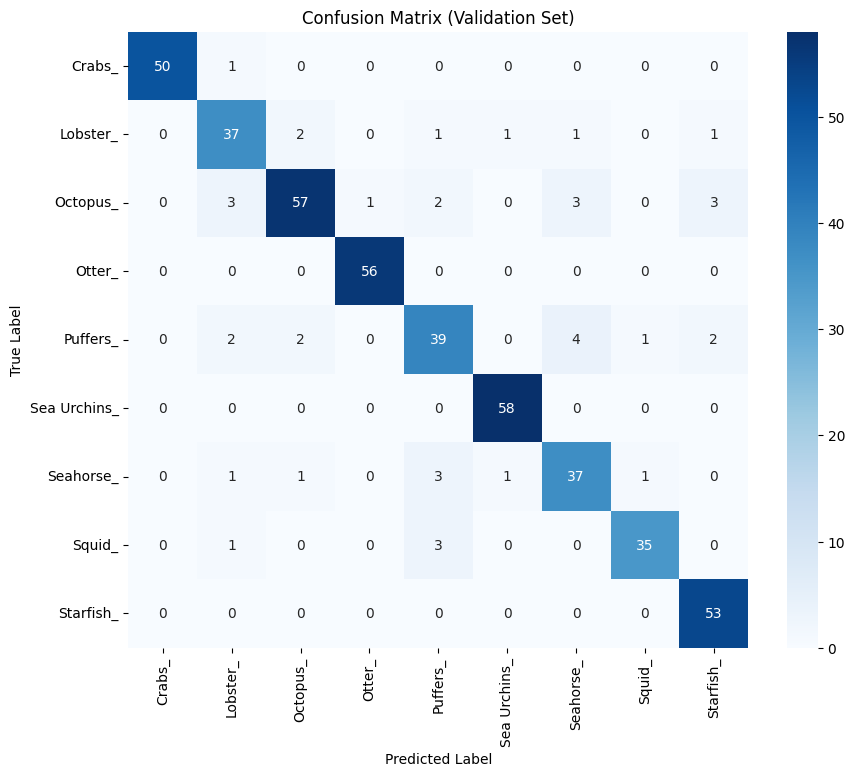

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

Thực hiện kiểm tra đánh giá trên tập test

In [ ]:
def evaluate_with_report(model, test_ds, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
              precision    recall  f1-score   support

      Crabs_       1.00      0.95      0.98        21
    Lobster_       0.85      0.92      0.88        24
    Octopus_       0.82      0.88      0.85        26
      Otter_       0.97      1.00      0.98        29
    Puffers_       0.76      0.96      0.85        23
Sea Urchins_       1.00      1.00      1.00        25
   Seahorse_       1.00      0.86      0.93        29
      Squid_       0.95      0.72      0.82        25
   Starfish_       1.00      1.00      1.00        29

    accuracy                           0.92       231
   macro avg       0.93      0.92      0.92       231
weighted avg       0.93 

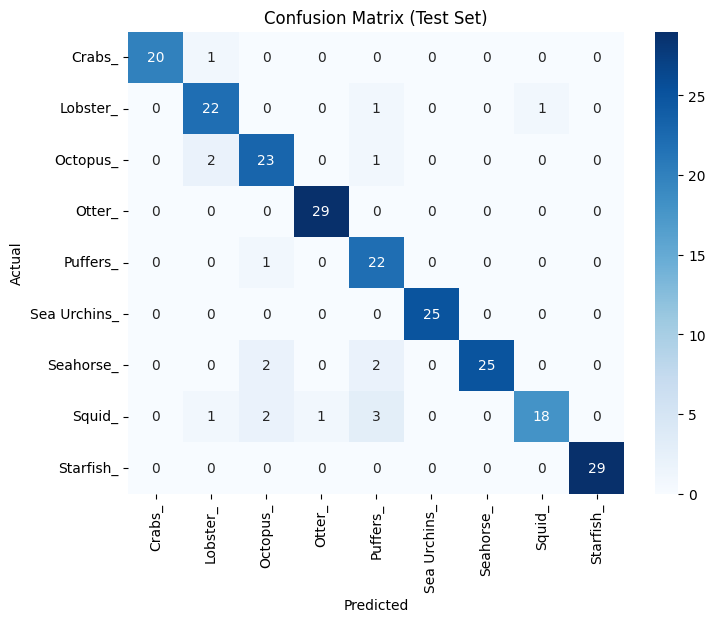

In [ ]:
evaluate_with_report(model, test_ds, class_names)